In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_blobs


In [3]:
np.random.seed(0)
X, y = make_blobs(n_samples=200, n_features=2,cluster_std=0.5, centers=2)

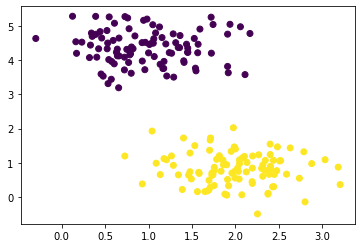

In [4]:
plt.scatter(X[:, 0], X[:, 1],c=y)

In [5]:
X_concat = np.hstack((np.ones((len(y), 1)), X))
X_concat.shape

(200, 3)

In [6]:
import seaborn as sns
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [7]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    theta = pm.Normal("theta", mu=0, sigma=100, shape=3)
    #theta = pm.Uniform("theta", upper=50, lower=-50, shape=3)
    X_ = pm.Data('features', X_concat)
    # Expected value of outcome
    
    y_hat = pm.math.sigmoid(tt.dot(X_, theta))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("Y_obs", p=y_hat, observed=y)

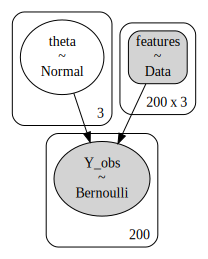

In [8]:
pm.model_to_graphviz(basic_model.model)


In [9]:
map_estimate = pm.find_MAP(model=basic_model)

In [10]:
map_estimate

{'theta': array([20.12421332,  3.69334159, -9.60226941])}

In [11]:
#separating hyperplane; X\theta = 0
def hyperplane(x, theta): 
    return (-theta[1]*x-theta[0]) /(theta[2])

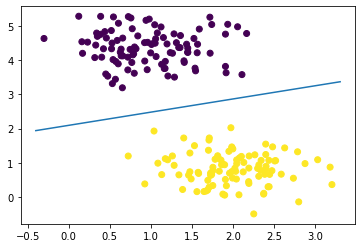

In [12]:
x = np.linspace(X[:, 0].min()-0.1, X[:, 0].max()+0.1, 100)
plt.plot(x, hyperplane(x, map_estimate['theta']))
plt.scatter(X[:, 0], X[:, 1],c=y)

In [13]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(2000,return_inferencedata=False,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
There were 1037 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1089 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6271662865285772, but should be close to 0.8. Try to increase the number of tuning steps.
There were 790 divergences after tuning. Increase `target_accept` or reparameterize.
There were 660 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2ba61e0d0>,
      dtype=object)

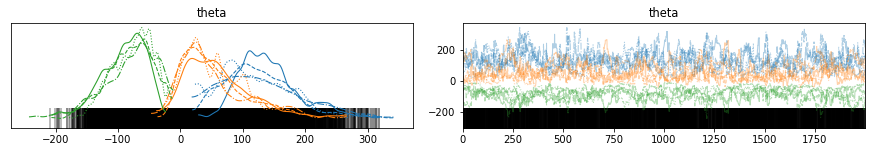

In [14]:
az.plot_trace(trace)

In [15]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

In [16]:
X_test = np.c_[xx.ravel(), yy.ravel()]
X_test_concat = np.hstack((np.ones((len(X_test), 1)), X_test))
X_test_concat.shape

(4368, 3)

In [17]:
with basic_model:
    pm.set_data({'features': X_test_concat})
    posterior = pm.sample_posterior_predictive(trace)

In [18]:
Z = posterior['Y_obs']

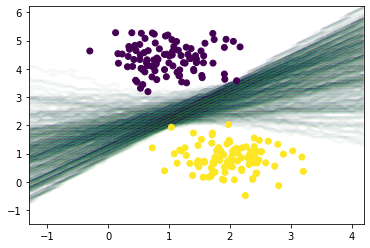

In [21]:
for i in range(len(Z))[:500]:
    plt.contour(xx, yy, Z[i].reshape(xx.shape), alpha=0.01)
plt.scatter(X[:, 0], X[:, 1],c=y, zorder=10)

FOllowing code inspired from": https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html

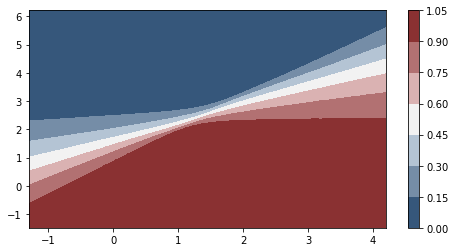

In [41]:
pred = posterior['Y_obs'].mean(axis=0)>0.5
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 4))
contour = plt.contourf(xx, yy, posterior['Y_obs'].mean(axis=0).reshape(xx.shape),cmap=cmap)
#ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
#ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
#cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");


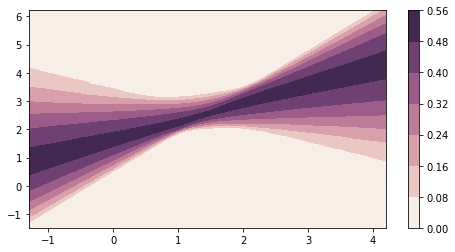

In [43]:
pred = posterior['Y_obs'].mean(axis=0)>0.5
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 4))
contour = plt.contourf(xx, yy, posterior['Y_obs'].std(axis=0).reshape(xx.shape),cmap=cmap)
#ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1])
#ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="r")
cbar = plt.colorbar(contour, ax=ax)
#_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
#cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");